In this tutorial, use Camber to generate some [Modules for Experiments in Stellar Astrophysics (MESA)](https://docs.mesastar.org/en/24.08.1/) Stellar Tracks. 
Watch a population of stars evolve from the pre-main-sequence (pMS) to the zero-age-main-sequence (ZAMS), and then evolve them once more to the end of their hydrogen core-burning phase of evolution.

To execute the workload efficiently, this tutorial uses the [`scatter_job()`](/docs/tutorials/scatter/) to execute many simulations in parallel.
In short, the flow is as follows:
1. Initialize a set of [inlist](https://docs.mesastar.org/en/24.08.1/using_mesa/building_inlists.html) files, essentially a configuration file that defines the parameters to evolve one star.
1. Execute one job for each of these inlists in parallel.
1. Plot the output of each evolution in one chart.

## Set up your MESA environment

First, import Camber and the libraries to do calculation and visualization:



In [1]:
import camber
import os
import pandas as pd 
import numpy as np
import smplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import mesa_reader as mr




Then, define a function that creates an ensemble of stellar tracks, ranging in mass from `minMass` to `maxMass` with an interval size `dm`.



In [2]:
def create_table(minMass, maxMass, dm):
    # Calculate the number of intervals
    num_intervals = int((maxMass - minMass) / dm) + 1    
    # Generate the values based on the intervals
    values = [minMass + i * dm for i in range(num_intervals)]
    # Generate ZAMS file names
    zams_file = [f"{round(val, 1)}Msun_zams.mod" for val in values]
    hcore_file = [f"{round(val, 1)}Msun_hcore.mod" for val in values]
    #outdir= [f"{val}Msun" for val in values]
    # Create a DataFrame
    df = pd.DataFrame({'mass': values, 'zams_file':zams_file,'hcore_file':hcore_file})
    return df

Let's range between 1-2 Msuns with an interval of 0.5 Msun. 

In [3]:
minMass=1.0 ## 
maxMass=4.5
dm=0.5
df = create_table(minMass,maxMass,dm)
df

,mass,zams_file,hcore_file
0,1.0,1.0Msun_zams.mod,1.0Msun_hcore.mod
1,1.5,1.5Msun_zams.mod,1.5Msun_hcore.mod
2,2.0,2.0Msun_zams.mod,2.0Msun_hcore.mod
3,2.5,2.5Msun_zams.mod,2.5Msun_hcore.mod
4,3.0,3.0Msun_zams.mod,3.0Msun_hcore.mod
5,3.5,3.5Msun_zams.mod,3.5Msun_hcore.mod
6,4.0,4.0Msun_zams.mod,4.0Msun_hcore.mod
7,4.5,4.5Msun_zams.mod,4.5Msun_hcore.mod




## Generate inlist files

Now generate ZAMS stars from pMS collapse. To generate a ZAMS star, specify an inlist that includes the function `create_pre_main_sequence_model = .true.`
This inlist is called `inlist_create_zams`.
Note that the `param_sets` variable is going to be passed as an agrument to the MESA [`create_scatter_job`](/docs/python-api/engines/mesa/#create_scatter_job) method.
These params are the template for the jobs to execute in parallel.



In [4]:
jobs = camber.mesa.create_scatter_job(
    param_sets=[
        {
            "INLIST": "'inlist_create_zams'",
            "OUTPUT_MOD": '"' + str(row['zams_file']) + '"',  # Add extra quotes around the value
            "INIT_MASS": str(row['mass'])
        }
        for _, row in df.iterrows()
    ],
    inlist_files = ['inlist','inlist_create_zams'],
    engine_size='SMALL'
)



This may take a few minutes on a small engine. To view the job status, you can return the `jobs` object:



In [12]:
jobs

[CamberJob({"job_id": 6955, "status": "COMPLETED", "engine_size": "SMALL", "engine_type": "MESA", "command": "./mk && ./rn", "with_gpu": false}),
 CamberJob({"job_id": 6953, "status": "COMPLETED", "engine_size": "SMALL", "engine_type": "MESA", "command": "./mk && ./rn", "with_gpu": false}),
 CamberJob({"job_id": 6948, "status": "COMPLETED", "engine_size": "SMALL", "engine_type": "MESA", "command": "./mk && ./rn", "with_gpu": false}),
 CamberJob({"job_id": 6951, "status": "COMPLETED", "engine_size": "SMALL", "engine_type": "MESA", "command": "./mk && ./rn", "with_gpu": false}),
 CamberJob({"job_id": 6949, "status": "COMPLETED", "engine_size": "SMALL", "engine_type": "MESA", "command": "./mk && ./rn", "with_gpu": false}),
 CamberJob({"job_id": 6952, "status": "COMPLETED", "engine_size": "SMALL", "engine_type": "MESA", "command": "./mk && ./rn", "with_gpu": false}),
 CamberJob({"job_id": 6954, "status": "COMPLETED", "engine_size": "SMALL", "engine_type": "MESA", "command": "./mk && ./rn",



Once all statuses are `COMPLETED`, you've generated your ZAMS files! Camber creates a final ZAMS model, appended with `zams.mod`, in each of the respective directories. 
These ZAMS mod files are the requisite input files to evolve our stars from ZAMS to the next stage of evolution (in our case, H-Core burning).


Let's move these files to our main directory:



In [13]:
!find $(pwd) -maxdepth 1 -type d -name "00*" -exec sh -c 'cp "$1"/*.mod $(pwd)' sh {} \;



Now evolve each of our ZAMS stellar tracks along the H-core burning sequence.
To parameterize this, define another table of `param_sets`:



In [14]:
param_sets=[
    {   
        "INLIST": "'inlist_hcoreburning'",
        "INPUT_MOD": '"' + str(row['zams_file']) + '"',  # Add extra quotes around the value
        "INIT_MASS": str(row['mass']),
        "OUTPUT_MOD": '"' + str(row['hcore_file']) + '"',  # Add extra quotes around the value
    }
    for _, row in df.iterrows()]
param_sets

[{'INLIST': "'inlist_hcoreburning'",
  'INPUT_MOD': '"1.0Msun_zams.mod"',
  'INIT_MASS': '1.0',
  'OUTPUT_MOD': '"1.0Msun_hcore.mod"'},
 {'INLIST': "'inlist_hcoreburning'",
  'INPUT_MOD': '"1.5Msun_zams.mod"',
  'INIT_MASS': '1.5',
  'OUTPUT_MOD': '"1.5Msun_hcore.mod"'},
 {'INLIST': "'inlist_hcoreburning'",
  'INPUT_MOD': '"2.0Msun_zams.mod"',
  'INIT_MASS': '2.0',
  'OUTPUT_MOD': '"2.0Msun_hcore.mod"'},
 {'INLIST': "'inlist_hcoreburning'",
  'INPUT_MOD': '"2.5Msun_zams.mod"',
  'INIT_MASS': '2.5',
  'OUTPUT_MOD': '"2.5Msun_hcore.mod"'},
 {'INLIST': "'inlist_hcoreburning'",
  'INPUT_MOD': '"3.0Msun_zams.mod"',
  'INIT_MASS': '3.0',
  'OUTPUT_MOD': '"3.0Msun_hcore.mod"'},
 {'INLIST': "'inlist_hcoreburning'",
  'INPUT_MOD': '"3.5Msun_zams.mod"',
  'INIT_MASS': '3.5',
  'OUTPUT_MOD': '"3.5Msun_hcore.mod"'},
 {'INLIST': "'inlist_hcoreburning'",
  'INPUT_MOD': '"4.0Msun_zams.mod"',
  'INIT_MASS': '4.0',
  'OUTPUT_MOD': '"4.0Msun_hcore.mod"'},
 {'INLIST': "'inlist_hcoreburning'",
  'INPUT_MO

In [15]:


zams_mod_files = [file for file in os.listdir("./") if file.endswith("zams.mod")]
zams_mod_files=sorted(zams_mod_files)





Run another `scatter_job` with the H-Core burning inlist files:



In [26]:
jobs = camber.mesa.create_scatter_job(
    param_sets=[
        {   "INLIST": "'inlist_hcoreburning'",
            "INPUT_MOD":str(row['zams_file']),
            "OUTPUT_MOD": str(row['hcore_file']),
            "INIT_MASS": str(row['mass'])
        }
        for _, row in df.iterrows()
    ],
    inlist_files = ['inlist','inlist_hcoreburning'],
    model_files=zams_mod_files,
    engine_size='SMALL'
)



This too takes just a few minutes to complete, but you can start plotting as soon as your files begin to be generated.
Check the status with:



In [31]:
for i in range(len(jobs)):
    print(jobs[i].job_id, ": ", jobs[i].status)
    

6967 :  RUNNING
6970 :  RUNNING
6966 :  RUNNING
6965 :  RUNNING
6964 :  RUNNING
6969 :  RUNNING
6968 :  RUNNING
6971 :  RUNNING




Once the statuses are `RUNNING`, you can start to plot results.

## Plot results



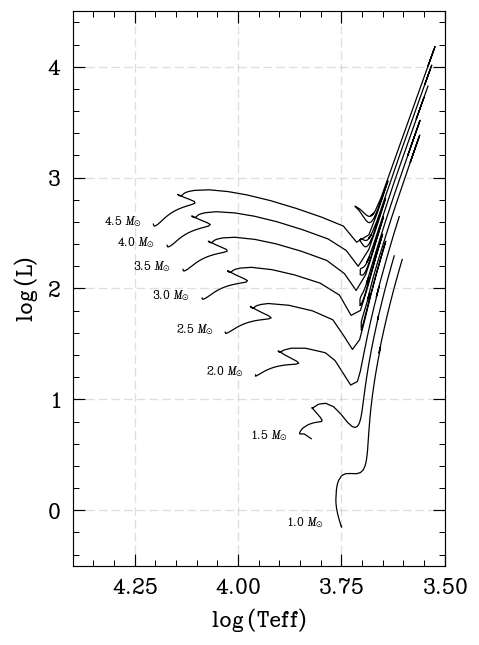

In [32]:
fig = plt.figure(figsize=(4,6))
maxx=4.4
minx=3.5
miny=-0.5
maxy=4.5

dirs = sorted([file for file in os.listdir("./") if file.startswith("00")])
for d in dirs:
    h=mr.MesaData(str(d)+'/LOGS/history.data')
    plt.plot(h.log_Teff,h.log_L,linewidth=0.75,zorder=1,label=str(round(h.star_mass[0],4))+' $M_{\odot}$',color='black')
    plt.annotate(str(round(h.star_mass[0],4))+' $M_{\odot}$', (max(h.log_Teff)+0.12,h.log_L[0]),fontsize=8)

plt.xlim(maxx,minx)
plt.ylim(miny,maxy)
plt.grid(alpha=0.25)
plt.xlabel('$\log$(Teff)')
plt.ylabel('$\log$(L)')
plt.show()





It's always a good practice to clean-up after yourself. Go ahead and clear the jobs:



In [28]:
# Uncomment when you're sure you want to stop the jobs
# for job in jobs:
#    job.clear()

Fin!